# Capstone Project - The Battle of Neighborhoods

# Title - Where Tim Hortons should open its first shop in Los Angeles

## Introduction

#### Background

Tim Hortons is Canada’s largest and most popular fast-food restaurant with 4300 shops in Canada. The brand is known for its coffee and baked goods. Although the brand is popular in Canada, it has not found the same level of success in the United States. With about 730 shops there and the majority opened in New York, the company has declining average sales every year. 

#### Problem

To increase their sales, Tim Hortons should open shops in Los Angeles. Los Angeles is the second-most populous city in the United States, and coffee shops are very popular there. Tim Hortons needs to locate the shops in busy neighborhoods where coffee shops are frequently visited in order for their sales and profits to increase. This project aims to discover the neighborhood in Los Angeles where Tim Hortons should open their first shop.


### Step 1: Finding all Neighborhoods in Los Angeles

Scrapping the name of all neighborhoods from Los Angeles Times website.

In [220]:
import pandas as pd

url='http://maps.latimes.com/neighborhoods/neighborhood/list/'

df_all=pd.read_html(url, header=0)[0]

df_all.head(12)

Name                  Region
0               Acton         Antelope Valley
1     Adams-Normandie              South L.A.
2        Agoura Hills  Santa Monica Mountains
3          Agua Dulce        Northwest County
4            Alhambra      San Gabriel Valley
5        Alondra Park               South Bay
6            Altadena                Verdugos
7       Angeles Crest          Angeles Forest
8             Arcadia      San Gabriel Valley
9              Arleta     San Fernando Valley
10  Arlington Heights            Central L.A.
11            Artesia               Southeast

In [221]:
print('There are {} neighborhoods in Los Angeles'.format(df_all.shape[0]))

There are 272 neighborhoods in Los Angeles


Change 'Name' to 'Neighborhood' and check for null values in the dataset.

In [222]:
df_all = df_all.rename(columns={'Name': 'Neighborhood'})
print('The table has {} null values'.format(df.isnull().values.sum()))

The table has 0 null values


In [223]:
df_all['Region'].value_counts()

San Gabriel Valley        47
San Fernando Valley       34
South L.A.                28
Central L.A.              26
Southeast                 26
Westside                  23
South Bay                 19
Harbor                    13
Antelope Valley           13
Northwest County          12
Northeast L.A.             7
Santa Monica Mountains     7
Verdugos                   7
Eastside                   4
Angeles Forest             3
Pomona Valley              3
Name: Region, dtype: int64

## Step 2: Using OpenCage to generate coordinates of all Neighborhoods

In [224]:
from opencage.geocoder import OpenCageGeocode

In [225]:
key = 'e1120a34d66e4ea1af893f8ee5b6d336'  # get api key from:  https://opencagedata.com

geocoder = OpenCageGeocode(key)


In [226]:
list_lat = []   # create empty lists

list_long = []


	
for index, row in df_all.iterrows(): # iterate over rows in dataframe



    neighbourhood = row['Neighborhood']
    #State = row['State']       
    query = str(neighbourhood)+','+ 'Los Angeles'

    results = geocoder.geocode(query)   
    lat = results[0]['geometry']['lat']
    long = results[0]['geometry']['lng']

    list_lat.append(lat)
    list_long.append(long)

	
# create new columns from lists    

df_all['Latitude'] = list_lat   

df_all['Longitude'] = list_long

In [227]:
df_all.head()

Neighborhood                  Region   Latitude   Longitude
0            Acton         Antelope Valley  34.480742 -118.186838
1  Adams-Normandie              South L.A.  34.033081 -118.297115
2     Agoura Hills  Santa Monica Mountains  34.147910 -118.765704
3       Agua Dulce        Northwest County  34.496382 -118.325635
4         Alhambra      San Gabriel Valley  34.093042 -118.127060

## Step 3: Visualizing Neighborhoods in Los Angeles

Import all the required libraries first.

In [228]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files


from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Generate the coordinate of Los Angeles.

In [229]:
address = 'Los Angeles, USA'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Los Angeles are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Los Angeles are 34.0536909, -118.2427666.


Using folium, generate the map of Los Angeles and mark all its neighborhoods.

In [230]:
#Display the map of Los Angeles

# create map of Los Angeles using latitude and longitude values
map_losangeles = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, city in zip(df_all['Latitude'], df_all['Longitude'], df_all['Neighborhood']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_losangeles)  
    
map_losangeles

## Step 4: Finding the trending venues in each Neighborhood

Set the credentials and versions.

In [231]:
CLIENT_ID = 'RPQJ3UYMNUFNJDQTM45IEFQPXHYEJ4I2R0V3MITANJ40LUPM' # your Foursquare ID
CLIENT_SECRET = 'ORDRLCRD3R4NWLZBLOFY2IZPVHQFWYXTVTJKUBS3IBKZANBQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RPQJ3UYMNUFNJDQTM45IEFQPXHYEJ4I2R0V3MITANJ40LUPM
CLIENT_SECRET:ORDRLCRD3R4NWLZBLOFY2IZPVHQFWYXTVTJKUBS3IBKZANBQ


Explore each neighborhood within 500 metres of their coordinates and retrieve venues. The limit of venues retrieved for each neighborhood is 100.

In [232]:
radius = 500
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
url



'https://api.foursquare.com/v2/venues/explore?client_id=RPQJ3UYMNUFNJDQTM45IEFQPXHYEJ4I2R0V3MITANJ40LUPM&client_secret=ORDRLCRD3R4NWLZBLOFY2IZPVHQFWYXTVTJKUBS3IBKZANBQ&ll=34.0536909,-118.2427666&v=20180605&radius=500&limit=100'

Generate the category for each venue.

In [233]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [234]:
def getNearbyVenues(neighborhood, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(neighborhood, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [235]:
losangeles_venues = getNearbyVenues(neighborhood=df_all['Neighborhood'],
                                   latitudes=df_all['Latitude'],
                                   longitudes=df_all['Longitude']
                                  )

Acton
Adams-Normandie
Agoura Hills
Agua Dulce
Alhambra
Alondra Park
Altadena
Angeles Crest
Arcadia
Arleta
Arlington Heights
Artesia
Athens
Atwater Village
Avalon
Avocado Heights
Azusa
Baldwin Hills/Crenshaw
Baldwin Park
Bel-Air
Bell
Bellflower
Bell Gardens
Beverly Crest
Beverly Grove
Beverly Hills
Beverlywood
Boyle Heights
Bradbury
Brentwood
Broadway-Manchester
Burbank
Calabasas
Canoga Park
Carson
Carthay
Castaic
Castaic Canyons
Central-Alameda
Century City
Cerritos
Charter Oak
Chatsworth
Chatsworth Reservoir
Chesterfield Square
Cheviot Hills
Chinatown
Citrus
Claremont
Commerce
Compton
Covina
Cudahy
Culver City
Cypress Park
Del Aire
Del Rey
Desert View Highlands
Diamond Bar
Downey
Downtown
Duarte
Eagle Rock
East Compton
East Hollywood
East La Mirada
East Los Angeles
East Pasadena
East San Gabriel
Echo Park
Elizabeth Lake
El Monte
El Segundo
El Sereno
Elysian Park
Elysian Valley
Encino
Exposition Park
Fairfax
Florence
Florence-Firestone
Gardena
Glassell Park
Glendale
Glendora
Gramercy P

KeyError: 'groups'

In [236]:
print(losangeles_venues.shape)
losangeles_venues.head()

(5112, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Adams-Normandie              34.033081             -118.297115   
1  Adams-Normandie              34.033081             -118.297115   
2  Adams-Normandie              34.033081             -118.297115   
3  Adams-Normandie              34.033081             -118.297115   
4  Adams-Normandie              34.033081             -118.297115   

               Venue  Venue Latitude  Venue Longitude    Venue Category  
0      Ignatius Cafe       34.031772      -118.293006              Café  
1  Orange Door Sushi       34.032485      -118.299368  Sushi Restaurant  
2              Shell       34.033095      -118.300025       Gas Station  
3      Sushi Delight       34.032445      -118.299525  Sushi Restaurant  
4        Little Xian       34.032292      -118.299465  Sushi Restaurant

Modify the table grouping by neighborhood.

In [237]:
losangeles_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                   
Adams-Normandie                                            9   
Agoura Hills                                               8   
Agua Dulce                                                 7   
Alhambra                                                  43   
Alondra Park                                               4   
Altadena                                                  21   
Angeles Crest                                              3   
Arcadia                                                    8   
Arleta                                                     4   
Arlington Heights                                          4   
Artesia                                                   32   
Athens                                                     4   
Atwater Village                                           39   
Avalon                                                    46   
Avocado Heights                                            3   
Azusa                                                     26   
Baldwin Hills/Crenshaw                                    42   
Baldwin Park                                              38   
Bel-Air                                                    8   
Bell                                                      19   
Bell Gardens                                               8   
Bellflower                                                 3   
Beverly Grove                                              4   
Beverly Hills                                             72   
Beverlywood                                                1   
Boyle Heights                                              7   
Bradbury                                                   2   
Brentwood                                                 19   
Broadway-Manchester                                        2   
Burbank                                                   14   
Canoga Park                                               18   
Carson                                                     6   
Carthay                                                   34   
Castaic                                                    6   
Castaic Canyons                                           78   
Central-Alameda                                           20   
Century City                                              81   
Cerritos                                                   5   
Charter Oak                                               18   
Chatsworth                                                19   
Chatsworth Reservoir                                      19   
Chesterfield Square                                       12   
Cheviot Hills                                              8   
Chinatown                                                 42   
Citrus                                                     4   
Claremont                                                 62   
Commerce                                                  14   
Compton                                                   14   
Covina                                                    14   
Cudahy                                                    10   
Culver City                                               42   
Cypress Park                                               8   
Del Aire                                                   7   
Del Rey                                                    4   
Diamond Bar                                                7   
Downey                                                     5   
Duarte                                                    32   
East Compton                                               4   
East Hollywood                                             7   
East La Mirada                                             2   
East Los Angeles                                           9   
East Pa

Create one hot array since there are many different categories.

In [238]:
# one hot encoding
losangeles_onehot = pd.get_dummies(losangeles_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
losangeles_onehot['Neighborhood'] = losangeles_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [losangeles_onehot.columns[-1]] + list(losangeles_onehot.columns[:-1])
losangeles_onehot = losangeles_onehot[fixed_columns]

losangeles_onehot.head()

Zoo Exhibit  ATM  Accessories Store  Adult Boutique  Advertising Agency  \
0            0    0                  0               0                   0   
1            0    0                  0               0                   0   
2            0    0                  0               0                   0   
3            0    0                  0               0                   0   
4            0    0                  0               0                   0   

   African Restaurant  Airport  American Restaurant  Amphitheater  \
0                   0        0                    0             0   
1                   0        0                    0             0   
2                   0        0                    0             0   
3                   0        0                    0             0   
4                   0        0                    0             0   

   Antique Shop  Aquarium  Arcade  Argentinian Restaurant  Art Gallery  \
0             0         0       0                       0            0   
1             0         0       0                       0            0   
2             0         0       0                       0            0   
3             0         0       0                       0            0   
4             0         0       0                       0            0   

   Art Museum  Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0           0                    0                     0                 0   
1           0                    0                     0                 0   
2           0                    0                     0                 0   
3           0                    0                     0                 0   
4           0                    0                     0                 0   

   Athletics & Sports  Australian Restaurant  Auto Dealership  Auto Garage  \
0                   0                      0                0            0   
1                   0                      0                0            0   
2                   0                      0                0            0   
3                   0                      0                0            0   
4                   0                      0                0            0   

   Auto Workshop  Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  Bakery  \
0              0                0          0           0           0       0   
1              0                0          0           0           0       0   
2              0                0          0           0           0       0   
3              0                0          0           0           0       0   
4              0                0          0           0           0       0   

   Bank  Bar  Baseball Field  Basketball Court  Basketball Stadium  Beach  \
0     0    0               0                 0                   0      0   
1     0    0               0                 0                   0      0   
2     0    0               0                 0                   0      0   
3     0    0               0                 0                   0      0   
4     0    0               0                 0                   0      0   

   Beer Bar  Beer Garden  Beer Store  Big Box Store  Bike Rental / Bike Share  \
0         0            0           0              0                         0   
1         0            0           0              0                         0   
2         0            0           0              0                         0   
3         0            0           0              0                         0   
4         0            0           0              0                         0   

   Bistro  Board Shop  Boat Rental  Boat or Ferry  Bookstore  Boutique  \
0       0           0            0              0          0         0   
1       0           0            0              0          0         0   
2       0           0            0              0          0         0   
3       0

In [239]:
losangeles_grouped = losangeles_onehot.groupby('Neighborhood').mean().reset_index()
losangeles_grouped

Neighborhood  Zoo Exhibit       ATM  \
0                          Adams-Normandie     0.000000  0.000000   
1                             Agoura Hills     0.000000  0.000000   
2                               Agua Dulce     0.000000  0.000000   
3                                 Alhambra     0.000000  0.000000   
4                             Alondra Park     0.000000  0.000000   
5                                 Altadena     0.000000  0.000000   
6                            Angeles Crest     0.000000  0.000000   
7                                  Arcadia     0.000000  0.000000   
8                                   Arleta     0.000000  0.000000   
9                        Arlington Heights     0.000000  0.000000   
10                                 Artesia     0.000000  0.000000   
11                                  Athens     0.000000  0.000000   
12                         Atwater Village     0.000000  0.000000   
13                                  Avalon     0.000000  0.021739   
14                         Avocado Heights     0.000000  0.000000   
15                                   Azusa     0.000000  0.000000   
16                  Baldwin Hills/Crenshaw     0.000000  0.000000   
17                            Baldwin Park     0.000000  0.000000   
18                                 Bel-Air     0.000000  0.000000   
19                                    Bell     0.000000  0.000000   
20                            Bell Gardens     0.000000  0.000000   
21                              Bellflower     0.000000  0.000000   
22                           Beverly Grove     0.000000  0.000000   
23                           Beverly Hills     0.000000  0.013889   
24                             Beverlywood     0.000000  0.000000   
25                           Boyle Heights     0.000000  0.000000   
26                                Bradbury     0.000000  0.000000   
27                               Brentwood     0.000000  0.000000   
28                     Broadway-Manchester     0.000000  0.000000   
29                                 Burbank     0.000000  0.000000   
30                             Canoga Park     0.000000  0.000000   
31                                  Carson     0.000000  0.000000   
32                                 Carthay     0.000000  0.000000   
33                                 Castaic     0.000000  0.000000   
34                         Castaic Canyons     0.000000  0.000000   
35                         Central-Alameda     0.000000  0.000000   
36                            Century City     0.000000  0.000000   
37                                Cerritos     0.000000  0.000000   
38                             Charter Oak     0.000000  0.000000   
39                              Chatsworth     0.000000  0.000000   
40                    Chatsworth Reservoir     0.000000  0.000000   
41                     Chesterfield Square     0.000000  0.000000   
42                           Cheviot Hills     0.000000  0.000000   
43                               Chinatown     0.000000  0.000000   
44                                  Citrus     0.000000  0.000000   
45                               Claremont     0.000000  0.000000   
46                                Commerce     0.000000  0.000000   
47                                 Compton     0.000000  0.000000   
48                                  Covina     0.000000  0.000000   
49                                  Cudahy     0.000000  0.000000   
50                             Culver City     0.000000  0.000000   
51                            Cypress Park     0.000000  0.000000   
52                                Del Aire     0.000000  0.000000   
53                                 Del Rey     0.000000  0.000000   
54                             Diamond Bar     0.000000  0.000000   
55                                  Downey     0.000000  0.000000   
56                                  Duarte     0.000000  0.000000   
57                          

Retrieve top 5 common venues in each neighborhood

In [240]:
num_top_venues = 5

for hood in losangeles_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = losangeles_grouped[losangeles_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adams-Normandie----
              venue  freq
0  Sushi Restaurant  0.33
1              Food  0.11
2        Taco Place  0.11
3       Gas Station  0.11
4              Café  0.11


----Agoura Hills----
               venue  freq
0      Deli / Bodega  0.12
1  Indian Restaurant  0.12
2     Breakfast Spot  0.12
3        Gas Station  0.12
4                Gym  0.12


----Agua Dulce----
                venue  freq
0           Gift Shop  0.14
1              Bakery  0.14
2  Mexican Restaurant  0.14
3         Pizza Place  0.14
4       Grocery Store  0.14


----Alhambra----
              venue  freq
0    Ice Cream Shop  0.07
1            Bakery  0.07
2      Burger Joint  0.05
3  Sushi Restaurant  0.05
4              Café  0.05


----Alondra Park----
                  venue  freq
0  Gym / Fitness Center  0.25
1        Baseball Field  0.25
2          Home Service  0.25
3                  Park  0.25
4           Zoo Exhibit  0.00


----Altadena----
           venue  freq
0  Grocery Store  0.10
1  

4     Korean Restaurant  0.07


----Compton----
                  venue  freq
0  Fast Food Restaurant  0.21
1           Pizza Place  0.14
2   Fried Chicken Joint  0.07
3        Sandwich Place  0.07
4              Pharmacy  0.07


----Covina----
                  venue  freq
0  Fast Food Restaurant  0.21
1        Sandwich Place  0.07
2    Chinese Restaurant  0.07
3              Pharmacy  0.07
4    Mexican Restaurant  0.07


----Cudahy----
                  venue  freq
0  Fast Food Restaurant   0.3
1   American Restaurant   0.1
2        Clothing Store   0.1
3           Pizza Place   0.1
4            Donut Shop   0.1


----Culver City----
                 venue  freq
0          Coffee Shop  0.07
1          Pizza Place  0.05
2            Gastropub  0.05
3  American Restaurant  0.05
4   Italian Restaurant  0.05


----Cypress Park----
                venue  freq
0  Mexican Restaurant  0.25
1                Park  0.12
2              Bakery  0.12
3      Discount Store  0.12
4   Food & Drink Sh

                 venue  freq
0                Trail   1.0
1            Pet Store   0.0
2  Peruvian Restaurant   0.0
3   Persian Restaurant   0.0
4         Perfume Shop   0.0


----Hollywood Hills West----
                 venue  freq
0                Trail   1.0
1            Pet Store   0.0
2  Peruvian Restaurant   0.0
3   Persian Restaurant   0.0
4         Perfume Shop   0.0


----Huntington Park----
                 venue  freq
0  Fried Chicken Joint  0.25
1    Accessories Store  0.25
2         Burger Joint  0.25
3   Mexican Restaurant  0.25
4    Outdoor Sculpture  0.00


----Hyde Park----
           venue  freq
0    Pizza Place  0.22
1          Motel  0.11
2      Bookstore  0.11
3     Taco Place  0.11
4  Grocery Store  0.11


----Industry----
                   venue  freq
0     Chinese Restaurant  0.31
1      Korean Restaurant  0.06
2     Seafood Restaurant  0.06
3  Vietnamese Restaurant  0.06
4         Ice Cream Shop  0.06


----Inglewood----
                  venue  freq
0       

4  North Indian Restaurant  0.05


----North Whittier----
           venue  freq
0  Deli / Bodega  0.25
1        Dog Run  0.25
2  Indie Theater  0.25
3           Food  0.25
4       Pet Café  0.00


----Northridge----
                venue  freq
0  Mexican Restaurant  0.07
1  Chinese Restaurant  0.04
2        Burger Joint  0.04
3                Bank  0.04
4         Coffee Shop  0.04


----Northwest Palmdale----
                  venue  freq
0   Japanese Restaurant  0.11
1  Fast Food Restaurant  0.11
2    Mexican Restaurant  0.05
3          Dance Studio  0.05
4        Sandwich Place  0.05


----Norwalk----
              venue  freq
0       Coffee Shop  0.18
1  Department Store  0.09
2    Ice Cream Shop  0.09
3     Movie Theater  0.09
4              Bank  0.09


----Pacific Palisades----
                 venue  freq
0       Ice Cream Shop  0.07
1          Supermarket  0.05
2                 Bank  0.05
3   Chinese Restaurant  0.05
4  American Restaurant  0.05


----Pacoima----
            

                  venue  freq
0           Pizza Place  0.09
1    Chinese Restaurant  0.06
2  Fast Food Restaurant  0.04
3                  Bank  0.04
4              Pharmacy  0.04


----South San Gabriel----
                   venue  freq
0     Chinese Restaurant  0.19
1  Vietnamese Restaurant  0.16
2   Fast Food Restaurant  0.06
3       Asian Restaurant  0.03
4               Pharmacy  0.03


----South San Jose Hills----
                venue  freq
0                Pool   0.5
1          Sports Bar   0.5
2         Zoo Exhibit   0.0
3  Persian Restaurant   0.0
4        Perfume Shop   0.0


----South Whittier----
              venue  freq
0             Trail  0.25
1          Pharmacy  0.25
2              Park  0.25
3  Business Service  0.25
4       Zoo Exhibit  0.00


----Stevenson Ranch----
                  venue  freq
0            Donut Shop  0.12
1            Food Truck  0.12
2    Frozen Yogurt Shop  0.12
3                 Trail  0.12
4  Gym / Fitness Center  0.12


----Studio City---

                venue  freq
0    Department Store  0.05
1  Frozen Yogurt Shop  0.05
2  Mexican Restaurant  0.05
3   Mobile Phone Shop  0.05
4       Grocery Store  0.05


----Westlake----
                       venue  freq
0       Fast Food Restaurant  0.13
1             Clothing Store  0.07
2                       Park  0.07
3               Intersection  0.03
4  South American Restaurant  0.03


----Westmont----
                   venue  freq
0   Fast Food Restaurant  0.33
1  Performing Arts Venue  0.33
2             Donut Shop  0.33
3            Zoo Exhibit  0.00
4           Outlet Store  0.00


----Westwood----
                  venue  freq
0    Italian Restaurant  0.25
1          Liquor Store  0.25
2  Fast Food Restaurant  0.25
3           Coffee Shop  0.25
4              Pharmacy  0.00


----Whittier----
           venue  freq
0  Deli / Bodega  0.25
1        Dog Run  0.25
2  Indie Theater  0.25
3           Food  0.25
4       Pet Café  0.00


----Whittier Narrows----
               

In [241]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create a data frame with top 4 common venues for each neighborhood.

In [242]:
num_top_venues = 4

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = losangeles_grouped['Neighborhood']

for ind in np.arange(losangeles_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(losangeles_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0  Adams-Normandie      Sushi Restaurant           Gas Station   
1     Agoura Hills         Deli / Bodega        Breakfast Spot   
2       Agua Dulce         Grocery Store                Bakery   
3         Alhambra        Ice Cream Shop                Bakery   
4     Alondra Park  Gym / Fitness Center                  Park   

  3rd Most Common Venue 4th Most Common Venue  
0                  Café                  Food  
1                Bakery     Indian Restaurant  
2                  Café     Convenience Store  
3          Burger Joint                  Café  
4        Baseball Field          Home Service

## Step 5: Selecting Neighborhoods which has Coffee Shops as most visited place

Select the neighborhoods which has coffee shop as the most common venue visited.

In [243]:
most_common = neighborhoods_venues_sorted[ (neighborhoods_venues_sorted['1st Most Common Venue'] == "Coffee Shop")]
most_common = most_common.reset_index()
most_common = most_common.drop(columns='index')
most_common


Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0   Atwater Village           Coffee Shop           Pizza Place   
1      Century City           Coffee Shop            Food Truck   
2       Charter Oak           Coffee Shop   American Restaurant   
3         Claremont           Coffee Shop   American Restaurant   
4       Culver City           Coffee Shop             Gastropub   
5     Hermosa Beach           Coffee Shop                 Hotel   
6         Larchmont           Coffee Shop    Mexican Restaurant   
7         Los Feliz           Coffee Shop        Ice Cream Shop   
8           Norwalk           Coffee Shop             Multiplex   
9      Santa Monica           Coffee Shop                  Café   
10         Sawtelle           Coffee Shop          Intersection   
11       South Park           Coffee Shop            Sports Bar   
12   Windsor Square           Coffee Shop    Italian Restaurant   

     3rd Most Common Venue 4th Most Common Venue  
0                Pet Store            Restaurant  
1       Italian Restaurant           Salad Place  
2        Convenience Store        Discount Store  
3                   Bakery   Arts & Crafts Store  
4      American Restaurant       Thai Restaurant  
5               Board Shop            Restaurant  
6            Movie Theater                  Café  
7       Italian Restaurant           Pizza Place  
8           Ice Cream Shop      Department Store  
9                     Bank    Mexican Restaurant  
10  Furniture / Home Store  Gym / Fitness Center  
11      Mexican Restaurant   American Restaurant  
12               Juice Bar                  Bank

In [244]:
#find population
print('There are {} neighborhoods which have coffee shop as the 1st most common venue.' .format(most_common.shape[0]))

There are 13 neighborhoods which have coffee shop as the 1st most common venue.


## Step 6: Finding and adding the population in each Neighborhood

Read population data from excel file.

In [245]:
df_pop=pd.read_excel('losangles.xlsx')
df_pop

Neighborhood  Population
0     Atwater Village       29092
1        Century City        8554
2           Claremont       36015
3         Culver City       39283
4           Larchmont       62733
5           Los Feliz       45616
6            Monrovia       37061
7             Norwalk      106084
8   Pacific Palisades       24651
9        Santa Monica       92306
10           Sawtelle       45742
11         South Park       35323
12     Windsor Square        8495

Merge the most_common dataframe with df_pop, using inner join on Neighborhood.

In [246]:
df = pd.merge(most_common,df_pop[['Neighborhood','Population']],on='Neighborhood', how='inner')
df.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0  Atwater Village           Coffee Shop           Pizza Place   
1     Century City           Coffee Shop            Food Truck   
2        Claremont           Coffee Shop   American Restaurant   
3      Culver City           Coffee Shop             Gastropub   
4        Larchmont           Coffee Shop    Mexican Restaurant   

  3rd Most Common Venue 4th Most Common Venue  Population  
0             Pet Store            Restaurant       29092  
1    Italian Restaurant           Salad Place        8554  
2                Bakery   Arts & Crafts Store       36015  
3   American Restaurant       Thai Restaurant       39283  
4         Movie Theater                  Café       62733

Plot a bar chart to display the population of each neighborhood.

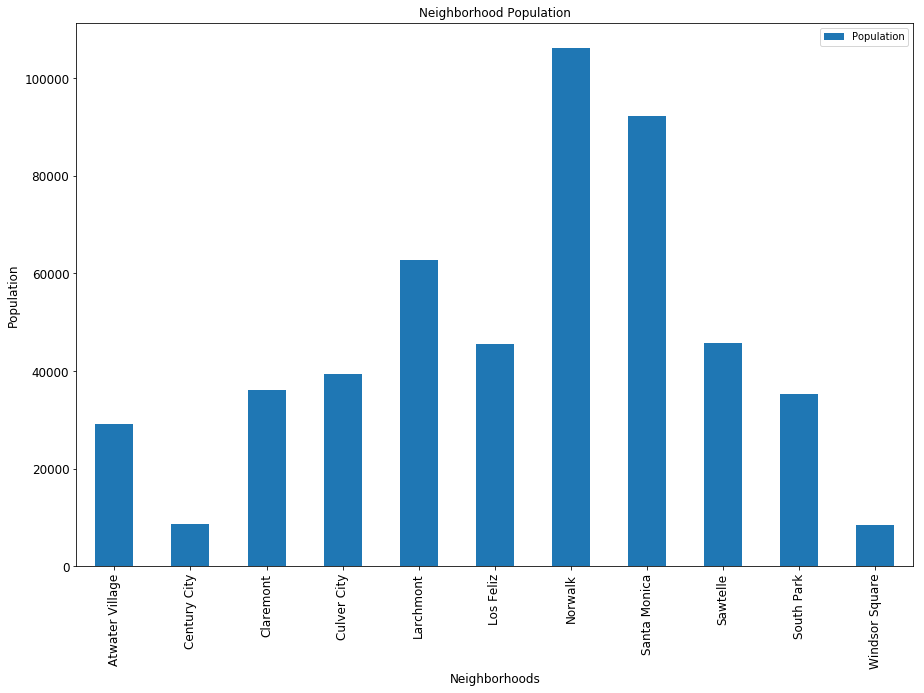

In [247]:
import matplotlib.pyplot as plt
ax = df[['Neighborhood','Population']].plot(x='Neighborhood',kind='bar', title ="Neighborhood Population", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Neighborhoods", fontsize=12)
ax.set_ylabel("Population", fontsize=12)
plt.show()


## Step 7: Short listing to two Neighborhoods with highest population

Select the 2 neighborhoods with the highest population.

In [248]:
df = df.sort_values(by=['Population'], ascending = False)
df_new = df.head(2)

In [249]:
df_new

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
6       Norwalk           Coffee Shop             Multiplex   
7  Santa Monica           Coffee Shop                  Café   

  3rd Most Common Venue 4th Most Common Venue  Population  
6        Ice Cream Shop      Department Store      106084  
7                  Bank    Mexican Restaurant       92306

## Step 8: Finding the number of Starbucks in the Neighborhoods

Locate the Starbucks shops in Norwalk.

In [250]:
import requests
from geopy.geocoders import Nominatim
address = 'Norwalk, Los Angeles'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

33.9092802 -118.0849169


Find the Starbucks' with in 10000 meters of the coordinate of Norwalk

In [251]:
search_query = 'Starbucks'
radius = 10000
print(search_query + ' .... OK!')
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

Starbucks .... OK!


name   categories                    address  cc              city  \
0   Starbucks  Coffee Shop       11790 Firestone Blvd  US           Norwalk   
1   Starbucks  Coffee Shop    14322 Pioneer Boulevard  US           Norwalk   
2   Starbucks  Coffee Shop      12200 Civic Center Dr  US           Norwalk   
3   Starbucks  Coffee Shop      11031 Firestone Blvd.  US           Norwalk   
4   Starbucks  Coffee Shop        11809 Artesia Blvd.  US           Artesia   
5   Starbucks  Coffee Shop      12751 Towne Center Dr  US          Cerritos   
6   Starbucks  Coffee Shop        14805 Thornlake Ave  US           Norwalk   
7   Starbucks  Coffee Shop          5538 Woodruff Ave  US          Lakewood   
8   Starbucks  Coffee Shop             11401 South St  US          Cerritos   
9   Starbucks  Coffee Shop  100 Citadel Dr, Suite 200  US          Commerce   
10  Starbucks  Coffee Shop     13001 Rosecrans Avenue  US           Norwalk   
11  Starbucks  Coffee Shop        9001 Firestone Blvd  US            Downey   
12  Starbucks  Coffee Shop        7876 Valley View St  US        Buena Park   
13  Starbucks  Coffee Shop    429 Los Cerritos Center  US          Cerritos   
14  Starbucks  Coffee Shop       10600 Firestone Blvd  US           Norwalk   
15  Starbucks  Coffee Shop          5906 Del Amo Blvd  US          Lakewood   
16  Starbucks  Coffee Shop     11023 Rosecrans Avenue  US           Norwalk   
17  Starbucks  Coffee Shop      14301 Bellflower Blvd  US        Bellflower   
18  Starbucks  Coffee Shop         13248 Imperial Hwy  US  Santa Fe Springs   
19  Starbucks  Coffee Shop   13819 Whittier Boulevard  US          Whittier   
20  Starbucks  Coffee Shop          8620 Garfield Ave  US        South Gate   
21  Starbucks  Coffee Shop      8754 Washington Blvd.  US       Pico Rivera   
22  Starbucks  Coffee Shop         8801 Lakewood Blvd  US            Downey   
23  Starbucks  Coffee Shop        12016 Lakewood Blvd  US            Downey   
24  Starbucks  Coffee Shop         4833 Candlewood St  US          Lakewood   
25  Starbucks  Coffee Shop      15905 Valley View Ave  US  Santa Fe Springs   
26  Starbucks  Coffee Shop         12501 Imperial Hwy  US           Norwalk   
27  Starbucks  Coffee Shop          8819 Alondra Blvd  US         Paramount   
28  Starbucks  Coffee Shop         14948 Imperial Hwy  US         La Mirada   
29  Starbucks  Coffee Shop        10737 Beverly Blvd.  US          Whittier   
30  Starbucks  Coffee Shop      12376 Washington Blvd  US          Whittier   
31  Starbucks  Coffee Shop          8231 La Palma Ave  US        Buena Park   
32  Starbucks  Coffee Shop          7724 Telegraph Rd  US          Commerce   
33  Starbucks  Coffee Shop      7000-F Eastern Avenue  US      Bell Gardens   
34  Starbucks  Coffee Shop        15200 Rosecrans Ave  US         La Mirada   
35  Starbucks  Coffee Shop           5897 Lincoln Ave  US        Buena Park   
36  Starbucks  Coffee Shop           3575 Katella Ave  US      Los Alamitos   
37  Starbucks  Coffee Shop       10031 Valley View St  US           Cypress   
38  Starbucks  Coffee Shop        17254 Lakewood Blvd  US        Bellflower   
39  Starbucks  Coffee Shop           7565 Carson Blvd  US        Long Beach   
40  Starbucks  Coffee Shop        12161 Carson Street  US  Hawaiian Gardens   
41  Starbucks  Coffee Shop   6756 S. Greenleaf Avenue  US          Whittier   
42  Starbucks  Coffee Shop      16610 Valley View Ave  US         La Mirada   
43  Starbucks  Coffee Shop            13704 Clark Ave  US        Bellflower   
44  Starbucks  Coffee Shop          4226 Woodruff Ave  US          Lakewood   
45  Starbucks  Coffee Shop      16601 Bellflower Blvd  US        Bellflower   
46  Starbucks  Coffee Shop           5373 Katella Ave  US           Cypress   
47  Starbucks  Coffee Shop        17254 Lakewood Blvd  US        Bellflower   
48  Starbucks  Coffee Shop         9329 Whittier Blvd  US       Pico Rivera   
49  Starbucks  Coffee Shop         800 W Beverly Blvd  US  

Select the Starbucks' that are only in the city Norwalk

In [252]:
dataframe_norwalk = dataframe_filtered[(dataframe_filtered.city == 'Norwalk')]
dataframe_norwalk.head(20)

name   categories                  address  cc     city  \
0   Starbucks  Coffee Shop     11790 Firestone Blvd  US  Norwalk   
1   Starbucks  Coffee Shop  14322 Pioneer Boulevard  US  Norwalk   
2   Starbucks  Coffee Shop    12200 Civic Center Dr  US  Norwalk   
3   Starbucks  Coffee Shop    11031 Firestone Blvd.  US  Norwalk   
6   Starbucks  Coffee Shop      14805 Thornlake Ave  US  Norwalk   
10  Starbucks  Coffee Shop   13001 Rosecrans Avenue  US  Norwalk   
14  Starbucks  Coffee Shop     10600 Firestone Blvd  US  Norwalk   
16  Starbucks  Coffee Shop   11023 Rosecrans Avenue  US  Norwalk   
26  Starbucks  Coffee Shop       12501 Imperial Hwy  US  Norwalk   

          country        crossStreet  distance  \
0   United States                NaN       427   
1   United States                NaN       904   
2   United States                NaN       324   
3   United States                NaN      1859   
6   United States                NaN      1872   
10  United States                NaN      2864   
14  United States                NaN      2761   
16  United States   at Studebaker Rd      1530   
26  United States  Norwalk Boulevard      1268   

                                     formattedAddress  \
0   [11790 Firestone Blvd, Norwalk, CA 90650, Unit...   
1   [14322 Pioneer Boulevard, Norwalk, CA 90650, U...   
2   [12200 Civic Center Dr, Norwalk, CA 90650, Uni...   
3   [11031 Firestone Blvd., Norwalk, CA 90650, Uni...   
6   [14805 Thornlake Ave, Norwalk, CA 90650, Unite...   
10  [13001 Rosecrans Avenue, Norwalk, CA 90650, Un...   
14  [10600 Firestone Blvd, Norwalk, CA 90650, Unit...   
16  [11023 Rosecrans Avenue (at Studebaker Rd), No...   
26  [12501 Imperial Hwy (Norwalk Boulevard), Norwa...   

                                       labeledLatLngs        lat         lng  \
0   [{'label': 'display', 'lat': 33.9123777633928,...  33.912378 -118.082175   
1   [{'label': 'display', 'lat': 33.901447, 'lng':...  33.901447 -118.082310   
2   [{'label': 'display', 'lat': 33.90637869292427...  33.906379 -118.084553   
3   [{'label': 'display', 'lat': 33.92201134855539...  33.922011 -118.097944   
6   [{'label': 'display', 'lat': 33.896264, 'lng':...  33.896264 -118.072077   
10  [{'label': 'display', 'lat': 33.90265385550381...  33.902654 -118.054962   
14  [{'label': 'display', 'lat': 33.925714, 'lng':...  33.925714 -118.107314   
16  [{'label': 'display', 'lat': 33.90238576347115...  33.902386 -118.099243   
26  [{'label': 'display', 'lat': 33.91799, 'lng': ...  33.917990 -118.076065   

   postalCode state                        id  
0       90650    CA  4b6989c6f964a52080a62be3  
1       90650    CA  4b5f8b4ff964a5209cc029e3  
2       90650    CA  4e4dd446bd41b76bef93d0b2  
3       90650    CA  52869069498e3289da675b54  
6       90650    CA  4f3272c519836c91c7d8d231  
10      90650    CA  4b957d02f964a52042a534e3  
14      90650    CA  4df642bac65bf55ee534b932  
16      90650    CA  534716bc498e040dc6edce66  
26      90650    CA  59370784a6ec982d000b3186

In [253]:
num_starbs_norwalk=dataframe_norwalk.shape[0]
print('There are {} Starbucks\' in Norwalk.'.format(num_starbs_norwalk))

There are 9 Starbucks' in Norwalk.


Locate the Starbucks' with in 10000 meters from the coordinate of Santa Monica.

In [254]:
address = 'Santa Monica, Los Angeles'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)
search_query = 'Starbucks'
radius = 10000
print(search_query + ' .... OK!')
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_sanmonica = dataframe_filtered[(dataframe_filtered.city == 'Santa Monica')]
dataframe_sanmonica.head(20)

34.0250724 -118.4965129
Starbucks .... OK!


name   categories                       address  \
0                      Starbucks  Coffee Shop     1356 3rd Street Promenade   
1                      Starbucks  Coffee Shop              1426 Montana Ave   
2                      Starbucks  Coffee Shop               820 Montana Ave   
3                      Starbucks  Coffee Shop               1705 Ocean Ave.   
4                      Starbucks  Coffee Shop             2200 Colorado Ave   
5                      Starbucks  Coffee Shop            2525 Wilshire Blvd   
6                      Starbucks  Coffee Shop            1311 Wilshire Blvd   
7                      Starbucks  Coffee Shop  2461 Santa Monica Blvd Ste A   
8                      Starbucks  Coffee Shop           1030 Wilshire Blvd.   
9                      Starbucks  Coffee Shop             3020 Lincoln Blvd   
10                     Starbucks  Coffee Shop                  710 Broadway   
11                     Starbucks  Coffee Shop               701 Montana Ave   
13                     Starbucks  Coffee Shop           395 Santa Monica Pl   
14                     Starbucks  Coffee Shop                  2671 Main St   
18                     Starbucks  Coffee Shop          2901 Ocean Park Blvd   
22  Starbucks Coffee Double Tree  Coffee Shop                   1707 4th St   
35  Starbucks (Starbucks Coffee)  Coffee Shop             2627 Lincoln Blvd   
39                     Starbucks  Coffee Shop             1900 Lincoln Blvd   
43                     Starbucks  Coffee Shop            3105 Wilshire Blvd   
44                     Starbucks  Coffee Shop             1447 Lincoln Blvd   

    cc          city        country       crossStreet  distance  \
0   US  Santa Monica  United States               NaN      1033   
1   US  Santa Monica  United States               NaN       897   
2   US  Santa Monica  United States            at 7th       444   
3   US  Santa Monica  United States  Civic Center Dr.      1654   
4   US  Santa Monica  United States               NaN      2102   
5   US  Santa Monica  United States               NaN      2120   
6   US  Santa Monica  United States               NaN       634   
7   US  Santa Monica  United States               NaN      2133   
8   US  Santa Monica  United States              11th       446   
9   US  Santa Monica  United States               NaN      3302   
10  US  Santa Monica  United States               NaN      1055   
11  US  Santa Monica  United States        7th Street       533   
13  US  Santa Monica  United States               NaN      1272   
14  US  Santa Monica  United States               NaN      2960   
18  US  Santa Monica  United States               NaN      3903   
22  US  Santa Monica  United States               NaN      1633   
35  US  Santa Monica  United States               NaN      2785   
39  US  Santa Monica  United States               NaN      1907   
43  US  Santa Monica  United States               NaN      2764   
44  US  Santa Monica  United States               NaN       975   

                                     formattedAddress  \
0   [1356 3rd Street Promenade, Santa Monica, CA 9...   
1   [1426 Montana Ave, Santa Monica, CA 90403, Uni...   
2   [820 Montana Ave (at 7th), Santa Monica, CA 90...   
3   [1705 Ocean Ave. (Civic Center Dr.), Santa Mon...   
4   [2200 Colorado Ave, Santa Monica, CA 90404, Un...   
5   [2525 Wilshire Blvd, Santa Monica, CA 90403, U...   
6   [1311 Wilshire Blvd, Santa Monica, CA 90403, U...   
7   [2461 Santa Monica Blvd Ste A, Santa Monica, C...   
8   [1030 Wilshire Blvd. (11th), Santa Monica, CA ...   
9   [3020 Lincoln Blvd, Santa Monica, CA 90405, Un...   
10  [710 Broadway, Santa Monica, CA 90401, United ...   
11  [701 Montana Ave (7th Street), Santa Monica, C...   
13  [395 Santa Monica Pl, Santa Monica, CA 90401, ...   
14  [2671 Main St, Santa Monica, CA 90405, United ...   
18  [2901 Ocean Park Blvd, Santa Monica, CA 90405,...   
22  [1707 4th St, Santa Monica, CA 90401, United

In [255]:
num_starbs_sanmonica=dataframe_sanmonica.shape[0]
print('There are {} Starbucks\' in Santa Monica'.format(num_starbs_sanmonica))

There are 20 Starbucks' in Santa Monica


In [257]:
df_new['Starbucks'] = num_starbs_norwalk, num_starbs_sanmonica


C:\Users\AhnaftheLegend\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [266]:
df_new['Customers per Shop'] = ( df_new['Population']/df_new['Starbucks']).astype(int)

C:\Users\AhnaftheLegend\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [267]:
df_new

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
6       Norwalk           Coffee Shop             Multiplex   
7  Santa Monica           Coffee Shop                  Café   

  3rd Most Common Venue 4th Most Common Venue  Population  Starbucks  \
6        Ice Cream Shop      Department Store      106084          9   
7                  Bank    Mexican Restaurant       92306         20   

   Customers per Shop  
6               11787  
7                4615

## Step 9: The Final Neighborhood - Santa Monica

Display the map of Santa Monica with all the Starbucks shops.

In [268]:
address = 'Santa Monica, Los Angeles'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)
search_query = 'Starbucks'
radius = 10000
print(search_query + ' .... OK!')
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_sanmonica = dataframe_filtered[(dataframe_filtered.city == 'Santa Monica')]
dataframe_sanmonica.head(20)

34.0250724 -118.4965129
Starbucks .... OK!


name   categories                       address  \
0                      Starbucks  Coffee Shop     1356 3rd Street Promenade   
1                      Starbucks  Coffee Shop              1426 Montana Ave   
2                      Starbucks  Coffee Shop               820 Montana Ave   
3                      Starbucks  Coffee Shop               1705 Ocean Ave.   
4                      Starbucks  Coffee Shop             2200 Colorado Ave   
5                      Starbucks  Coffee Shop            2525 Wilshire Blvd   
6                      Starbucks  Coffee Shop            1311 Wilshire Blvd   
7                      Starbucks  Coffee Shop  2461 Santa Monica Blvd Ste A   
8                      Starbucks  Coffee Shop           1030 Wilshire Blvd.   
9                      Starbucks  Coffee Shop             3020 Lincoln Blvd   
10                     Starbucks  Coffee Shop                  710 Broadway   
11                     Starbucks  Coffee Shop               701 Montana Ave   
13                     Starbucks  Coffee Shop           395 Santa Monica Pl   
14                     Starbucks  Coffee Shop                  2671 Main St   
18                     Starbucks  Coffee Shop          2901 Ocean Park Blvd   
22  Starbucks Coffee Double Tree  Coffee Shop                   1707 4th St   
35  Starbucks (Starbucks Coffee)  Coffee Shop             2627 Lincoln Blvd   
39                     Starbucks  Coffee Shop             1900 Lincoln Blvd   
43                     Starbucks  Coffee Shop            3105 Wilshire Blvd   
44                     Starbucks  Coffee Shop             1447 Lincoln Blvd   

    cc          city        country       crossStreet  distance  \
0   US  Santa Monica  United States               NaN      1033   
1   US  Santa Monica  United States               NaN       897   
2   US  Santa Monica  United States            at 7th       444   
3   US  Santa Monica  United States  Civic Center Dr.      1654   
4   US  Santa Monica  United States               NaN      2102   
5   US  Santa Monica  United States               NaN      2120   
6   US  Santa Monica  United States               NaN       634   
7   US  Santa Monica  United States               NaN      2133   
8   US  Santa Monica  United States              11th       446   
9   US  Santa Monica  United States               NaN      3302   
10  US  Santa Monica  United States               NaN      1055   
11  US  Santa Monica  United States        7th Street       533   
13  US  Santa Monica  United States               NaN      1272   
14  US  Santa Monica  United States               NaN      2960   
18  US  Santa Monica  United States               NaN      3903   
22  US  Santa Monica  United States               NaN      1633   
35  US  Santa Monica  United States               NaN      2785   
39  US  Santa Monica  United States               NaN      1907   
43  US  Santa Monica  United States               NaN      2764   
44  US  Santa Monica  United States               NaN       975   

                                     formattedAddress  \
0   [1356 3rd Street Promenade, Santa Monica, CA 9...   
1   [1426 Montana Ave, Santa Monica, CA 90403, Uni...   
2   [820 Montana Ave (at 7th), Santa Monica, CA 90...   
3   [1705 Ocean Ave. (Civic Center Dr.), Santa Mon...   
4   [2200 Colorado Ave, Santa Monica, CA 90404, Un...   
5   [2525 Wilshire Blvd, Santa Monica, CA 90403, U...   
6   [1311 Wilshire Blvd, Santa Monica, CA 90403, U...   
7   [2461 Santa Monica Blvd Ste A, Santa Monica, C...   
8   [1030 Wilshire Blvd. (11th), Santa Monica, CA ...   
9   [3020 Lincoln Blvd, Santa Monica, CA 90405, Un...   
10  [710 Broadway, Santa Monica, CA 90401, United ...   
11  [701 Montana Ave (7th Street), Santa Monica, C...   
13  [395 Santa Monica Pl, Santa Monica, CA 90401, ...   
14  [2671 Main St, Santa Monica, CA 90405, United ...   
18  [2901 Ocean Park Blvd, Santa Monica, CA 90405,...   
22  [1707 4th St, Santa Monica, CA 90401, United

In [269]:
import folium
venues_map = folium.Map(location=[latitude, longitude], zoom_start=14) # generate map centred around the Conrad Hotel

for lat, lng, label in zip(dataframe_sanmonica.lat, dataframe_sanmonica.lng, dataframe_sanmonica.categories):
    folium.features.Marker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

Make 2 Clusters of the Starbucks'

In [270]:
# clustering could be done here

# set number of clusters
kclusters = 2

losangeles_grouped_clustering = dataframe_sanmonica.drop(['name', 'categories','address','cc','city','country','id','state','postalCode','neighborhood','lat','lng','formattedAddress','labeledLatLngs','crossStreet'],1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(losangeles_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

losangeles_grouped_clustering.head()

distance
0      1033
1       897
2       444
3      1654
4      2102

In [271]:
dataframe_sanmonica.insert(0, 'Cluster Labels', kmeans.labels_)


dataframe_sanmonica.head()

Cluster Labels       name   categories                    address  cc  \
0               0  Starbucks  Coffee Shop  1356 3rd Street Promenade  US   
1               0  Starbucks  Coffee Shop           1426 Montana Ave  US   
2               0  Starbucks  Coffee Shop            820 Montana Ave  US   
3               0  Starbucks  Coffee Shop            1705 Ocean Ave.  US   
4               1  Starbucks  Coffee Shop          2200 Colorado Ave  US   

           city        country       crossStreet  distance  \
0  Santa Monica  United States               NaN      1033   
1  Santa Monica  United States               NaN       897   
2  Santa Monica  United States            at 7th       444   
3  Santa Monica  United States  Civic Center Dr.      1654   
4  Santa Monica  United States               NaN      2102   

                                    formattedAddress  \
0  [1356 3rd Street Promenade, Santa Monica, CA 9...   
1  [1426 Montana Ave, Santa Monica, CA 90403, Uni...   
2  [820 Montana Ave (at 7th), Santa Monica, CA 90...   
3  [1705 Ocean Ave. (Civic Center Dr.), Santa Mon...   
4  [2200 Colorado Ave, Santa Monica, CA 90404, Un...   

                                      labeledLatLngs        lat         lng  \
0  [{'label': 'display', 'lat': 34.01578714943329...  34.015787 -118.496415   
1  [{'label': 'display', 'lat': 34.03291536609515...  34.032915 -118.494249   
2  [{'label': 'display', 'lat': 34.027921, 'lng':...  34.027921 -118.499895   
3  [{'label': 'display', 'lat': 34.01079638301086...  34.010796 -118.491534   
4  [{'label': 'display', 'lat': 34.027093, 'lng':...  34.027093 -118.473852   

       neighborhood postalCode state                        id  
0               NaN      90401    CA  49bfbb5ef964a5201f551fe3  
1               NaN      90403    CA  4a7872cef964a520a9e51fe3  
2  Wilshire-Montana      90403    CA  4acf71e7f964a520b7d320e3  
3               NaN      90401    CA  53dd8710498e07ef7e12cce4  
4               NaN      90404    CA  4b0ac485f964a520852723e3

In [272]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(dataframe_sanmonica['lat'], dataframe_sanmonica['lng'], dataframe_sanmonica['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [273]:
number1 = dataframe_sanmonica[ dataframe_sanmonica['Cluster Labels'] == 1].shape[0]
number0 = dataframe_sanmonica[ dataframe_sanmonica['Cluster Labels'] == 0].shape[0]

In [274]:
print('The number of Starbucks shops in Purple Cluster are {}'.format(number1))
print('The number of Starbucks shops in Red Cluster are {}'.format(number0))

The number of Starbucks shops in Purple Cluster are 9
The number of Starbucks shops in Red Cluster are 11
